<center><font size="+2"><b><u> Relative peptide CA Z poisition </u></b></font></center>
<br></br>
<center> The following python script takes MD trajectories and works out the relative z position between the CA of each residues and the average phosphoate z position of the upper leaflet. -ve values indicate insertion into the hydrophobic core </center>

<b> To Do: </b>
<ul>
<li> Mininum distance from hydrophobic core?</li>
</ul>


By Philip Ferguson

In [2]:
import MDAnalysis
from MDAnalysis import analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
##gromacs configuration file###
gro_file = 'fullsys.gro'
##compressed trajectory file###
trajectory_file = 'final.xtc'
u = MDAnalysis.Universe('%s'%gro_file, '%s'%trajectory_file)
##### Sim start and sim end time
start = 0 
end = 200

In [3]:
#############INSERT INFO FOR PEPTIDE1 #####################
peptide = dict()
#### Single letter sequence #####
peptide['sequence'] = 'KSKEKIGKEFKRIVQRIKDFLRNLVPRTES'
#### Peptide name #####
peptide['peptide_name'] = 'KS-30'
#### Number of peptides #####
peptide['pepnum'] = 4
### DO NOT EDIT ###
peptide['resnum'] = len(peptide['sequence'])
peptide['restot'] = peptide['pepnum']*peptide['resnum']
peptide['starting_resid'] = 8

In [4]:
#create dictionary of amino acids 
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HSP': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
#invert to permit single letter to be entered
inv_map = {v: k for k, v in d.items()}
#create function to generate 3 letter code with residue position
def single_three(sequence,resnum):
    single = (list(sequence)) 
    Aminos=[]
    for i in range(0,(resnum)):
        value = single[i]
        Aminos.append((str(i+1))+inv_map[value])
    return Aminos
peptide['Aminos'] = single_three(peptide['sequence'],peptide['resnum'])

In [5]:
##split leaflets, find Z position for subtraction.
from MDAnalysis.analysis import leaflet
L = leaflet.LeafletFinder(u, 'name P')
### use split leaflets to find mean z position
p_up_mean = np.mean(L.groups(0).positions[:,[2]])
p_down_mean = np.mean(L.groups(1).positions[:,[2]])

In [6]:
##This is going to be used in the normal z position script
##NEeeds to be added to for synergy
def relative_zpos(peptide):
    output1=[]
    timecount1 =[]
    p_up1=[]
    ##This variable should allow synergy analysis
    for ts in u.trajectory[0::50]:
        for i in range(0,(peptide['resnum'])):
            resids = np.arange(peptide['starting_resid'],peptide['restot'],peptide['resnum'])+i
            temp1 = []
            #Create selection string
            for values in resids:
                temp2 = "resid %s"%values
                temp1.append(temp2)
            selection = ' or '.join(temp1)
            timecount1.append(u.trajectory.time)
            output1.append(np.mean(u.select_atoms("name CA and (%s)"%selection).positions[:,[2]].astype(float)))
            amino_num1 = peptide['Aminos']*int((len(output1)/peptide['resnum']))
            p_up1.append(np.mean(L.groups(0).positions[:,[2]]))
    z_position_array_pep1 = np.column_stack((timecount1,amino_num1,output1,p_up1))
    
    ##Create dataframe for plottting heatmap
    df = pd.DataFrame(z_position_array_pep1)
    df.rename(columns={ df.columns[0]: "Time (ns)", df.columns[1]: "Residue",
                           df.columns[2]: "CA Z position", df.columns[3]: "P" }, inplace = True)
    df['Residue']= df['Residue'].astype('str')
    df['CA Z position']= ((df['CA Z position'].astype(float)-df['P'].astype(float))/10)
    df['Time (ns)'] = df['Time (ns)'].astype(float)/1000
    df['Time (ns)'] = df['Time (ns)'].astype(int)
    column_order = list(df['Time (ns)'].unique())
    df = df.pivot(index='Residue',columns='Time (ns)', values='CA Z position')
    df = df.reindex(columns=column_order)
    df = df.reset_index()
    df['Section_Number'] = df['Residue'].str.replace('([A-Z]+)', '').astype(float)
    df = df.sort_values('Section_Number',ascending=False)
    df = df.drop('Section_Number',1)
    df = df.set_index('Residue')
    return df

In [7]:
#plot peptide 1
sns.set(font_scale=0.7)
ax = sns.heatmap(relative_zpos(peptide), vmax=1, vmin=-0.5,center=0,cmap="RdBu",
                cbar_kws={'label': 'Relative Z position (nm)'},yticklabels=1,xticklabels=20)
plt.tick_params(
    which='both', 
    width = 0.6,
    bottom=True,
    left=True,
    labelbottom=True) 
plt.xticks()
plt.xlim([start,(end+1)])
plt.savefig('Average_zposition_%s.png'%peptide['peptide_name'],dpi=300,bbox_inches="tight")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/philipferguson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-78a2e1376f41>", line 3, in <module>
    ax = sns.heatmap(relative_zpos(peptide), vmax=1, vmin=-0.5,center=0,cmap="RdBu",
  File "<ipython-input-6-a11f8308389a>", line 18, in relative_zpos
    output1.append(np.mean(u.select_atoms("name CA and (%s)"%selection).positions[:,[2]].astype(float)))
  File "/Users/philipferguson/.local/lib/python3.6/site-packages/MDAnalysis/core/universe.py", line 699, in select_atoms
    return self.atoms.select_atoms(*args, **kwargs)
  File "/Users/philipferguson/.local/lib/python3.6/site-packages/MDAnalysis/core/groups.py", line 2860, in select_atoms
    selections[0].apply(self))
  File "/Users/philipferguson/.local/lib/python3.6/site-packages/MDAnalysis/core/selection.py", line 141, in apply
    rsel = self.rsel.apply(g

KeyboardInterrupt: 

In [8]:
##This will take a snapshot at 300ns make a box plot with each point representing a peptide.
def box_plot_func(peptide,average):
    output=[]
    ##Variables cannot be inset into loop.  Work out why ??
    resnum = peptide['resnum']
    Aminos = peptide['Aminos']
    pepnum = peptide['pepnum']
    start_id = peptide['starting_resid']
    time_average = average*50
    for ts in u.trajectory[((end*50)-time_average):(end*50)+1:10]:
        for k in range(0,(pepnum)):
            temp1 =[]
            for i in range(start_id,(resnum+start_id)):
                number1 = i+(k*resnum)
                selection = ("name CA and resid %s"%number1)
                p_up = (np.mean(L.groups(0).positions[:,[2]]))
                temp = (np.mean(u.select_atoms("%s"%selection).positions[:,[2]]))
                peptide = [temp,Aminos[i-start_id],p_up,u.trajectory.time,k+1]
                output.append(peptide)
    return output

##Run function - dictionary,Time average from end in ns 
box = box_plot_func(peptide,20)

##Create dataframe for output
df_box1=pd.DataFrame(box)
df_box1.columns = ['CA Z position','Residue','P','Time (ns)','Pepnum']
df_box1['CA Z position']= ((df_box1['CA Z position'].astype(float)-df_box1['P'].astype(float))/10)
df_box1['peptide'] = "%s"%peptide['peptide_name']
df_box1 = df_box1.groupby(['Residue','Pepnum'],sort=False).mean().reset_index().drop(['P','Time (ns)'],1)
df_box1.to_csv('%s.csv'%peptide['peptide_name'], sep=',')

<center><font size="+2"><b><u> Distance between peptide COM and hydrophobic core </u></b></font></center>
<br></br>
<center> The following cells will take a snapshot at the end of the simulation and use this to make a box plot. Each point on the boxplot represents one peptide
<br></br>
<br></br>
A csv will ouput for a comparison plot and a plot will also be provided for this specific simulation</center>
<br></br>
<br></br>
<b> To Do: </b>
<ul>
<li> Create more dynamic function for higher order cominbatons</li>
</ul>


In [39]:
## center of mass and bilayer hydrophobic core
## Plot output in seperate z position plotting script
def peptide_hydrophobic_core(peptide):
    time_count=[]
    z_com = []
    for ts in u.trajectory[0::50]: 
        p_up = (np.mean(L.groups(0).positions[:,[2]]))
        p_down = (np.mean(L.groups(1).positions[:,[2]]))
        p_mid = (p_up+p_down)/2
        for i in range(0,peptide['pepnum']):
            start = (peptide['resnum']*i)+peptide['starting_resid']
            end = (peptide['resnum']*(i+1)+peptide['starting_resid'])-1
            selection = "resid " + str(start) + "-" + str(end)
            pep_com = u.select_atoms('%s'%selection).center_of_mass()[2]
            com_diff = pep_com - p_mid
            z_com.append([u.trajectory.time,com_diff])
    z_com_out = pd.DataFrame(z_com)
    return z_com_out


8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98
98 128
8 38
38 68
68 98

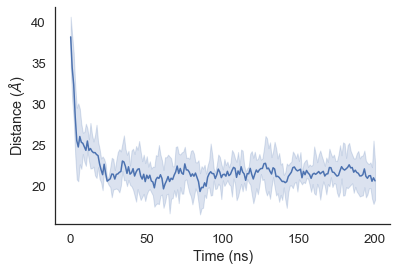

In [40]:
peptide_com = peptide_hydrophobic_core(peptide)
peptide_com.to_csv('peptide_com_%s.csv'%peptide['peptide_name'])

sns.set_style("white")
sns.lineplot(data=peptide_com,x=peptide_com[0]/1000,y=peptide_com[1])
sns.despine()
plt.xlabel("Time (ns)")
plt.ylabel(r'Distance ($\AA$)')
plt.savefig('peptide_com_distt_%s.png'%peptide['peptide_name'],dpi=300,bbox_inches="tight")